In [1]:
import pandas as pd

from nilearn import plotting
from nilearn.datasets import fetch_localizer_contrasts


In [2]:
# Fetch dataset
# -------------
# We download a list of left vs right button press contrasts from a
# localizer dataset.
n_subjects = 16
sample_vertical = fetch_localizer_contrasts(
    ["vertical checkerboard"],
    n_subjects,
    legacy_format=False,
)
sample_horizontal = fetch_localizer_contrasts(
    ["horizontal checkerboard"],
    n_subjects,
    legacy_format=False,
)

# Implicitly, there is a one-to-one correspondence between the two samples:
# the first image of both samples comes from subject S1,
# the second from subject S2 etc.


/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/nilearn/plotting/html_stat_map.py:198: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:870: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



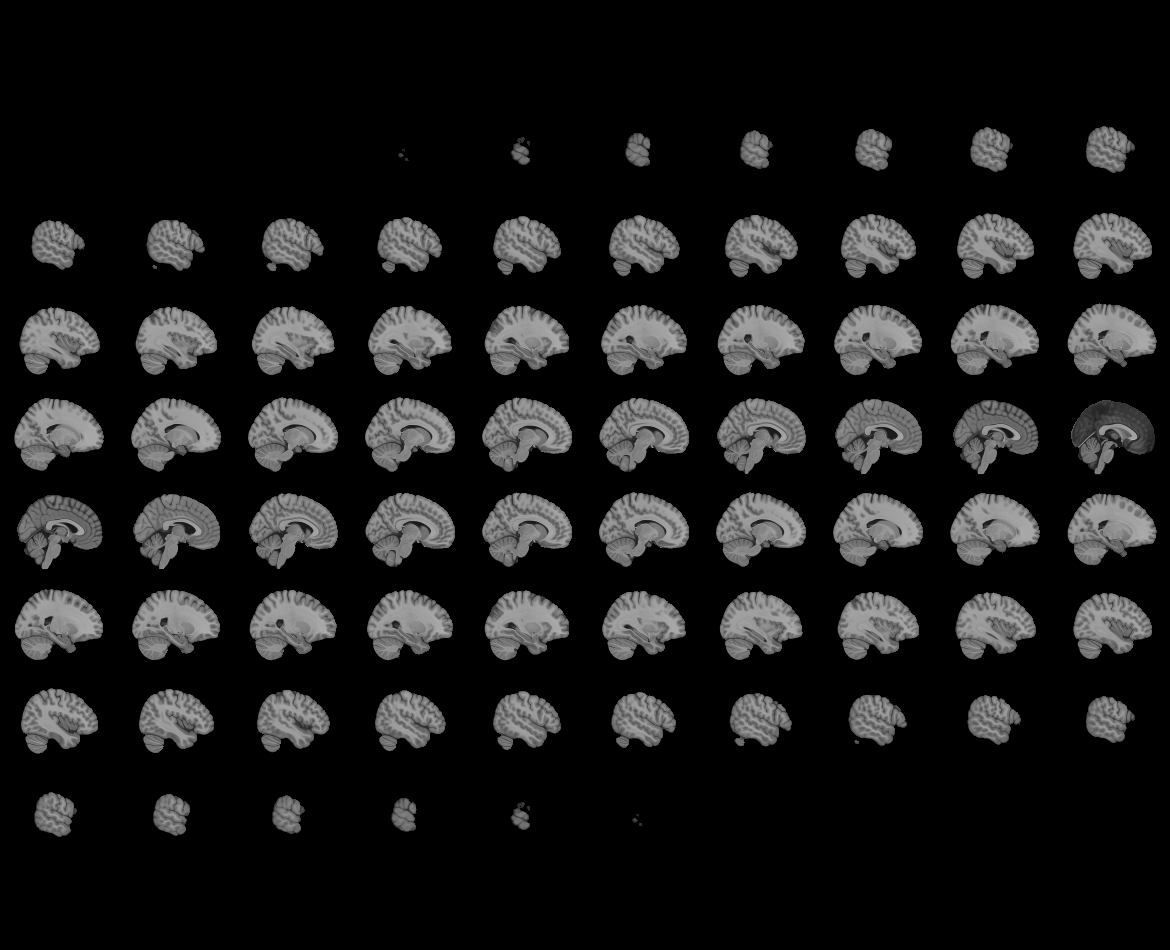
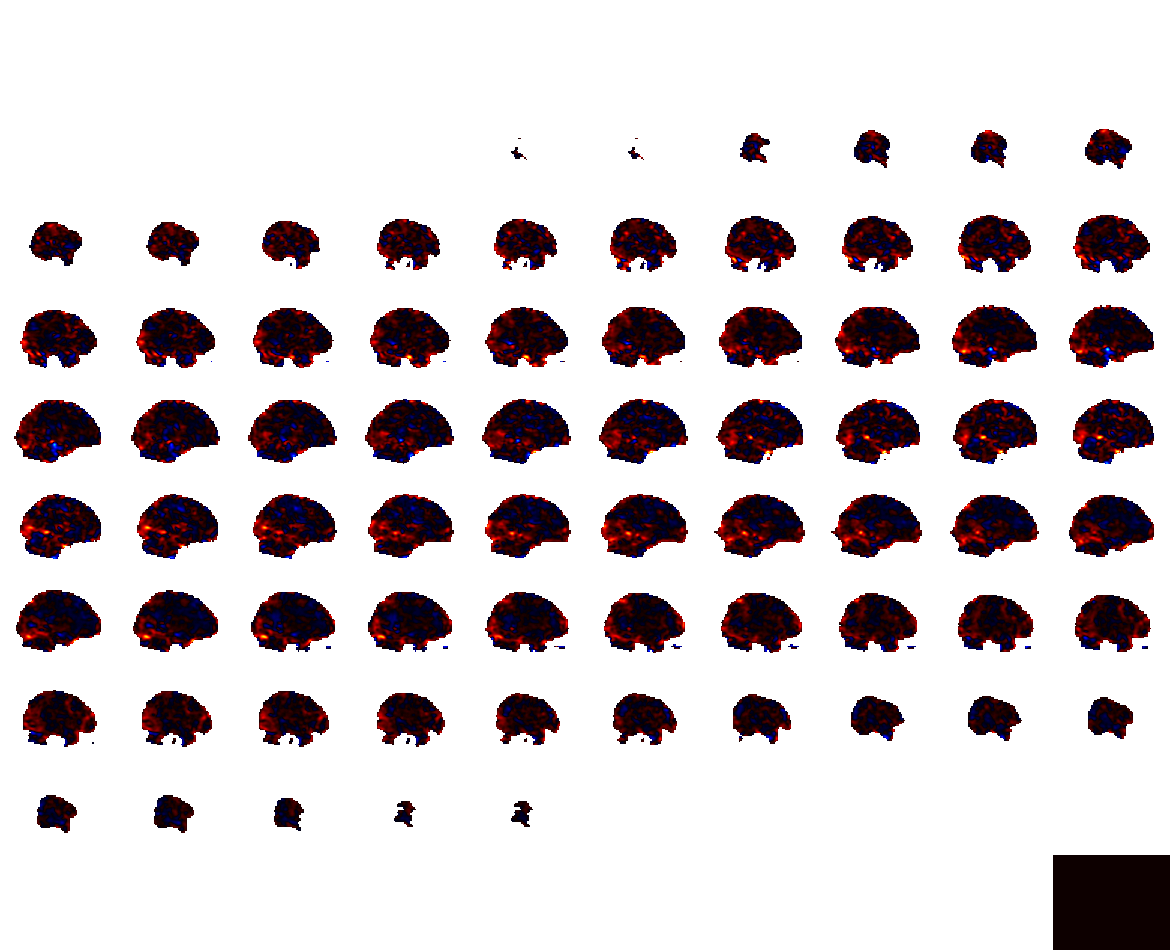

In [3]:
plotting.view_img(sample_vertical["cmaps"][10])

In [4]:
# Estimate second level models
# ----------------------------
# We define the input maps and the design matrix for the second level model
# and fit it.
second_level_input = sample_vertical["cmaps"] + sample_horizontal["cmaps"]


In [5]:
# Next, we model the effect of conditions (sample 1 vs sample 2).
import numpy as np

condition_effect = np.hstack(([1] * n_subjects, [0] * n_subjects))


In [6]:
# The design matrix for the unpaired test needs to add an intercept,
# For the paired test, we include an intercept for each subject.
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = [f"S{i:02d}" for i in range(1, n_subjects + 1)]


In [7]:
# We then assemble those into design matrices
unpaired_design_matrix = pd.DataFrame(
    {
        "vertical vs horizontal": condition_effect,
        "intercept": 1,
    }
)

paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["vertical vs horizontal", *subjects],
)


TypeError: plot_design_matrix() got an unexpected keyword argument 'axes'

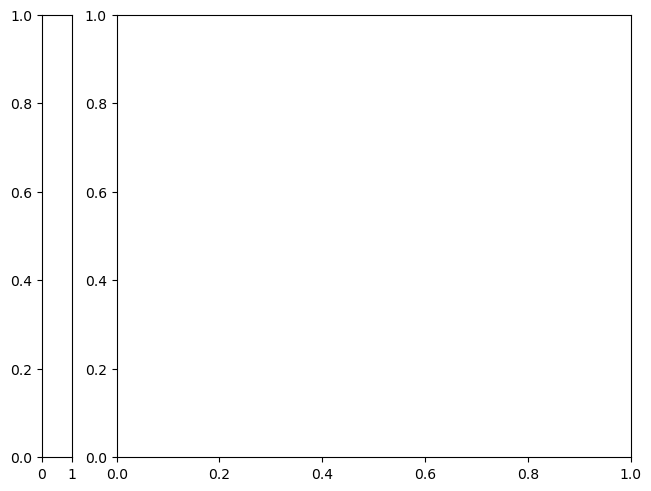

In [8]:
import matplotlib.pyplot as plt

_, (ax_unpaired, ax_paired) = plt.subplots(
    1,
    2,
    gridspec_kw={"width_ratios": [1, 17]},
    constrained_layout=True,
)


plotting.plot_design_matrix(
    unpaired_design_matrix, rescale=False, axes=ax_unpaired
)
plotting.plot_design_matrix(
    paired_design_matrix, rescale=False, axes=ax_paired
)
ax_unpaired.set_title("unpaired design", fontsize=12)
ax_paired.set_title("paired design", fontsize=12)
plotting.show()

In [9]:
# We specify the analysis models and fit them.
from nilearn.glm.second_level import SecondLevelModel

second_level_model_unpaired = SecondLevelModel(n_jobs=2).fit(
    second_level_input, design_matrix=unpaired_design_matrix
)

second_level_model_paired = SecondLevelModel(n_jobs=2).fit(
    second_level_input, design_matrix=paired_design_matrix
)


In [10]:
# Estimating the :term:`contrast` is simple. To do so, we provide the column
# name of the design matrix. The argument 'output_type' is set to return all
# available outputs so that we can compare differences in the effect size,
# variance, and z-score.
stat_maps_unpaired = second_level_model_unpaired.compute_contrast(
    "vertical vs horizontal", output_type="all"
)

stat_maps_paired = second_level_model_paired.compute_contrast(
    "vertical vs horizontal", output_type="all"
)


In [11]:
# Plot the results
# ----------------
# The two :term:`'effect_size'<Parameter Estimate>` images are essentially
# identical.
(
    stat_maps_unpaired["effect_size"].get_fdata()
    - stat_maps_paired["effect_size"].get_fdata()
).max()


np.float64(1.4210854715202004e-14)

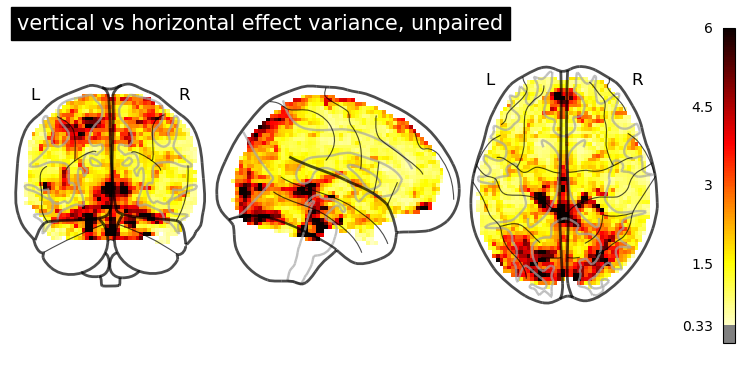

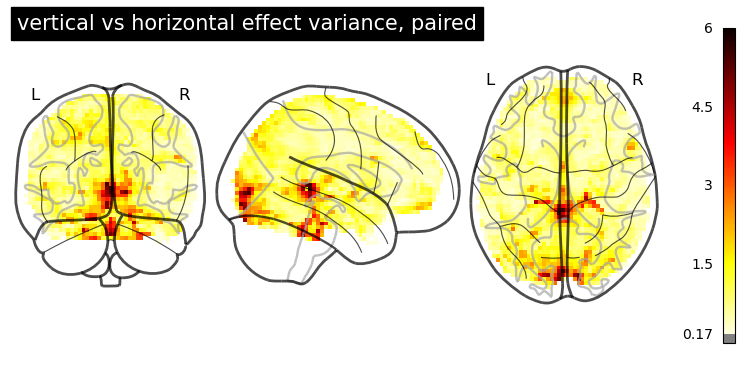

In [12]:
# But the variance in the unpaired image is larger.
plotting.plot_glass_brain(
    stat_maps_unpaired["effect_variance"],
    colorbar=True,
    vmin=0,
    vmax=6,
    title="vertical vs horizontal effect variance, unpaired",
)

plotting.plot_glass_brain(
    stat_maps_paired["effect_variance"],
    colorbar=True,
    vmin=0,
    vmax=6,
    title="vertical vs horizontal effect variance, paired",
)

plotting.show()


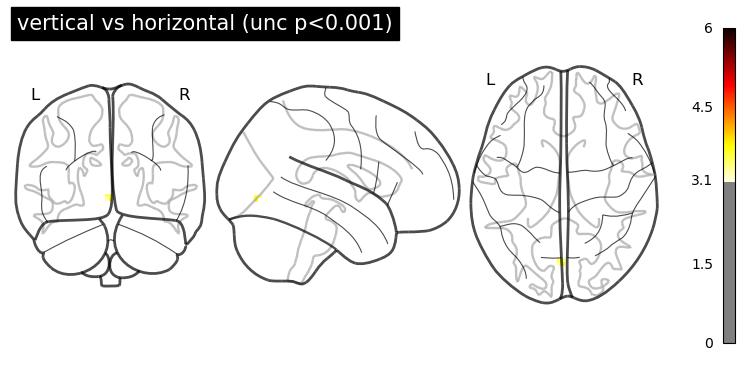

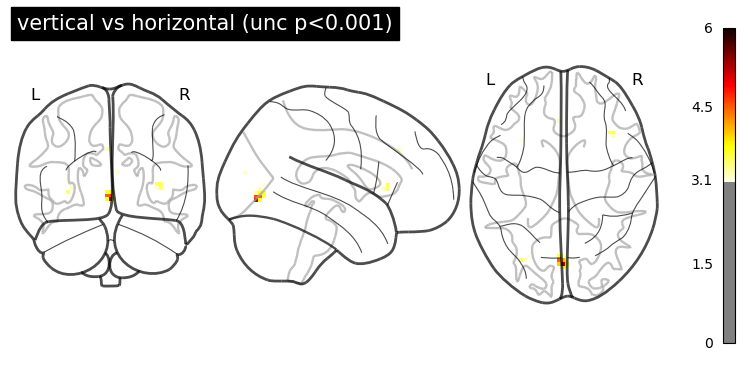

In [13]:
# Together, this makes the z_scores from the paired test larger.
# We threshold the second level :term:`contrast` and plot it.
threshold = 3.1  # corresponds to  p < .001, uncorrected
display = plotting.plot_glass_brain(
    stat_maps_unpaired["z_score"],
    threshold=threshold,
    colorbar=True,
    plot_abs=False,
    title="vertical vs horizontal (unc p<0.001)",
    vmin=0,
    vmax=6,
)

display = plotting.plot_glass_brain(
    stat_maps_paired["z_score"],
    threshold=threshold,
    colorbar=True,
    plot_abs=False,
    title="vertical vs horizontal (unc p<0.001)",
    vmin=0,
    vmax=6,
)

plotting.show()


In [ ]:
# Unsurprisingly, we see activity in the primary visual cortex, both positive
# and negative.
